In [18]:
%matplotlib inline

### Imports
- `numpy` for numerical operations and random message generation.
- `pyldpc` primitives: `make_ldpc`, `encode`, `decode`, and `get_message`.
- `matplotlib` for plotting and `time` for runtime measurement.

In [19]:
import numpy as np
from pyldpc import make_ldpc, decode, get_message, encode
from matplotlib import pyplot as plt
import time

### Code parameters
Selecting a short regular LDPC code close to a (128, 64) setting for demonstration:
- `n = 128`: code length.
- `d_v = 4`, `d_c = 8`: small degrees to keep `H` sparse.
- A fixed `seed` ensures reproducibility of the code construction and channel draws.


In [20]:
# Use a standard (128, 64) LDPC code, a common benchmark in research.
n = 128         # Codeword length
d_v = 4   # Variable node degree
d_c = 8   # Check node degree
seed = np.random.RandomState(42)

### Build the (n, k) LDPC code
Constructing a regular LDPC code using `make_ldpc`:
- `n` is the codeword length (number of variable nodes = columns of `H`).
- `d_v` / `d_c` are the variable/check node degrees (column/row weights of `H`).
- `systematic=True` returns a systematic generator `G` so that message extraction via `get_message(G, c)` is straightforward.
The code prints the resulting `(n, k)` and code rate for reference.


In [21]:
# Create the LDPC code matrices
print("Generating LDPC matrices for a (128, 64) code...")
H, G = make_ldpc(n, d_v, d_c, seed=seed, systematic=True, sparse=True)
n_code, k_info = G.shape
print(f"LDPC Code Parameters: n={n_code}, k={k_info}, Rate={k_info/n_code:.2f}")
print("-" * 30)

Generating LDPC matrices for a (128, 64) code...
LDPC Code Parameters: n=128, k=67, Rate=0.52
------------------------------


### Simulation parameters
Defining the SNR sweep and simulation size:
- `snrs_db`: the SNR range (in dB) focused on the waterfall region.
- `n_trials`: number of frames per SNR for stable BER estimates (increase for smoother curves).
- `max_iter_nms`: iteration cap for the BP/NMS decoder (increase if non-convergence warnings appear).


In [22]:
# Simulation parameters for robust results
snrs_db = np.linspace(0, 4, 9)  # Focus on the 'waterfall' region
n_trials = 10000                # Increased trials for statistical significance
max_iter_nms = 100              # Max iterations for the NMS decoder

### Two-stage decoding helpers
This cell defines the helper routines used by the hybrid decoder:
- `is_valid_codeword(H, c)`: parity-check validation via syndrome test `H·c == 0 (mod 2)`.
- `osd2_rescue(H, y, base, L, max_pairs)`: a low-complexity OSD-2-style rescue that flips least-reliable bits (single-bit first, then limited two-bit pairs).
- `two_stage_decoder(H, y, snr, maxiter)`: runs BP/NMS first; if parity fails, it triggers the OSD-2-style rescue and returns the best valid candidate found.


In [23]:
def is_valid_codeword(H, c: np.ndarray) -> bool:
    """Checks if a vector `c` is a valid codeword by computing the syndrome."""
    if c is None:
        return False
    # Syndrome s = H * c^T (mod 2)
    s = (H.dot(c) % 2).astype(int)
    return np.all(s == 0)

def osd2_rescue(H, y_channel: np.ndarray, base_decision: np.ndarray,
                L: int = 15, max_pairs: int = 200) -> np.ndarray:
    """
    Performs a simplified Order-2 OSD post-processing on a failed decoding attempt.
    It identifies the L least reliable bits from the channel observation `y_channel`
    and attempts to find a valid codeword by flipping 1 or 2 of them.
    """
    n = y_channel.shape[0]
    
    # Use absolute values of channel LLRs as reliability metric
    reliability = np.abs(y_channel)
    
    # Sort bit indices from least reliable to most reliable
    idx_sorted_by_reliability = np.argsort(reliability)
    
    # The set of L least reliable bits to be considered for flipping
    least_reliable_indices = idx_sorted_by_reliability[:min(L, n)]

    # Stage 1: Try flipping a single bit (Order-1 OSD)
    for i in least_reliable_indices:
        candidate = base_decision.copy()
        candidate[i] ^= 1  # Flip the bit
        if is_valid_codeword(H, candidate):
            return candidate

    # Stage 2: Try flipping a pair of bits (Order-2 OSD)
    # To prevent complexity explosion, we limit the number of pairs checked.
    pairs_checked = 0
    for i in range(len(least_reliable_indices)):
        for j in range(i + 1, len(least_reliable_indices)):
            idx1 = least_reliable_indices[i]
            idx2 = least_reliable_indices[j]
            
            candidate = base_decision.copy()
            candidate[idx1] ^= 1  # Flip first bit
            candidate[idx2] ^= 1  # Flip second bit
            
            if is_valid_codeword(H, candidate):
                return candidate
            
            pairs_checked += 1
            if pairs_checked >= max_pairs:
                # Return the original failed decision if no solution is found
                return base_decision

    return base_decision

def two_stage_decoder(H, y_channel: np.ndarray, snr: float, maxiter: int = 100) -> np.ndarray:
    """
    The main hybrid decoder.
    First, it runs a standard Belief Propagation (BP) decoder.
    If the BP decoder fails to find a valid codeword, it triggers the OSD rescue stage.
    """
    # Stage 1: Standard BP/NMS decoding
    decoded_word = decode(H, y_channel, snr, maxiter=maxiter)
    
    # Check if the result is a valid codeword
    if is_valid_codeword(H, decoded_word):
        return decoded_word
    
    # Stage 2: If BP failed, call OSD rescue
    # The base decision for OSD can be the failed BP output.
    return osd2_rescue(H, y_channel, decoded_word, L=15, max_pairs=200)

### BER simulation loop (Baseline vs Two-Stage)
This cell performs the main Monte Carlo simulation across SNR points:
- Generates random messages per SNR, encodes with `G`, and passes through an AWGN channel (handled by `encode`).
- Baseline decoding: BP/NMS via `decode(H, y, snr, maxiter=...)`.
- Two-Stage decoding: calls `two_stage_decoder` (BP first; if parity fails, OSD-2-style rescue).
- Counts bit errors using `get_message(G, c_hat)` and accumulates BER for each SNR.
- Prints per-SNR results and total runtime for progress tracking.


In [24]:
snrs_db = np.linspace(-1, 5, 12)  # SNR range in dB
n_trials = 2000                  # Number of frames to simulate per SNR point
max_bp_iter = 100

ber_baseline = []
ber_two_stage = []

rng_msg = np.random.RandomState(1234)

print("Starting BER simulation...")
start_time = time.time()

for snr in snrs_db:
    total_errors_baseline = 0
    total_errors_two_stage = 0
    
    # Generate a block of random messages for the current SNR
    v_messages = rng_msg.randint(2, size=(k_info, n_trials))
    
    # Encode messages and add AWGN noise
    y_noisy_codewords = encode(G, v_messages, snr, seed=seed)

    # Decode each noisy codeword column
    for i in range(n_trials):
        y_col = y_noisy_codewords[:, i]
        v_col = v_messages[:, i]
        
        # --- Baseline Decoder (BP/NMS only) ---
        d_baseline = decode(H, y_col, snr, maxiter=max_bp_iter)
        if d_baseline is not None:
            x_hat_baseline = get_message(G, d_baseline)
            total_errors_baseline += np.count_nonzero(x_hat_baseline != v_col)
        else: # Decoding failure
            total_errors_baseline += k_info

        # --- Two-Stage Decoder (BP/NMS + OSD) ---
        d_two_stage = two_stage_decoder(H, y_col, snr, maxiter=max_bp_iter)
        if d_two_stage is not None:
            x_hat_two_stage = get_message(G, d_two_stage)
            total_errors_two_stage += np.count_nonzero(x_hat_two_stage != v_col)
        else: # Should not happen if OSD returns base decision
             total_errors_two_stage += k_info

    ber_baseline.append(total_errors_baseline / (k_info * n_trials))
    ber_two_stage.append(total_errors_two_stage / (k_info * n_trials))
    
    print(f"  SNR={snr:.2f} dB: BER (Baseline) = {ber_baseline[-1]:.6f}, BER (NMS+OSD) = {ber_two_stage[-1]:.6f}")

end_time = time.time()
print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
print("-" * 30)


Starting BER simulation...
  SNR=-1.00 dB: BER (Baseline) = 0.182470, BER (NMS+OSD) = 0.182470
  SNR=-0.45 dB: BER (Baseline) = 0.165358, BER (NMS+OSD) = 0.165358
  SNR=0.09 dB: BER (Baseline) = 0.142366, BER (NMS+OSD) = 0.142366
  SNR=0.64 dB: BER (Baseline) = 0.117649, BER (NMS+OSD) = 0.117649
  SNR=1.18 dB: BER (Baseline) = 0.085425, BER (NMS+OSD) = 0.085425
  SNR=1.73 dB: BER (Baseline) = 0.054351, BER (NMS+OSD) = 0.054351
  SNR=2.27 dB: BER (Baseline) = 0.026709, BER (NMS+OSD) = 0.026709
  SNR=2.82 dB: BER (Baseline) = 0.011351, BER (NMS+OSD) = 0.011351
  SNR=3.36 dB: BER (Baseline) = 0.002694, BER (NMS+OSD) = 0.002694
  SNR=3.91 dB: BER (Baseline) = 0.000657, BER (NMS+OSD) = 0.000657
  SNR=4.45 dB: BER (Baseline) = 0.000276, BER (NMS+OSD) = 0.000276
  SNR=5.00 dB: BER (Baseline) = 0.000060, BER (NMS+OSD) = 0.000060
Simulation finished in 575.88 seconds.
------------------------------


### Plotting the BER curves
This cell visualizes the BER performance:
- X-axis: SNR (dB); Y-axis: BER on a logarithmic scale.
- Two curves: the Baseline BP/NMS decoder and the Two-Stage (BP/NMS + OSD-2 rescue).
- The grid and y-limits help interpret the waterfall region and error floors.


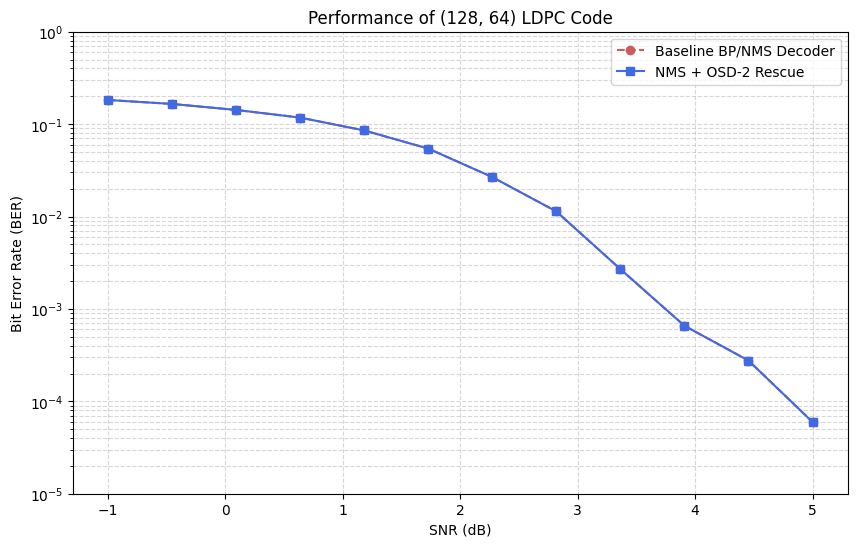

In [25]:
plt.figure(figsize=(10, 6))
plt.semilogy(snrs_db, ber_baseline, 'o--', label='Baseline BP/NMS Decoder', color='indianred')
plt.semilogy(snrs_db, ber_two_stage, 's-', label='NMS + OSD-2 Rescue', color='royalblue')
plt.title(f'Performance of (128, 64) LDPC Code')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.ylim(1e-5, 1) # Set y-axis limits for typical BER plots
plt.show()